In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Mars
from torchvision.transforms.v2 import (
    Compose, Resize, RandomCrop, CenterCrop,
    PILToTensor, ToPILImage, CutMix, MixUp )
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('highest')
device = "cuda:2"
dataset_train = load_dataset('danjacobellis/imagenet_288_webp',split='train')
dataset_valid = load_dataset('danjacobellis/imagenet_288_webp',split='validation')

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/256)*1e-3
config.min_lr = config.max_lr/100
config.plot_update = 128
config.epochs = 100
config.lr_scale = 1
config.lr_offset = 0.55
config.lr_pow1 = 8
config.lr_pow2 = 2
config.weight_decay = 0.0
config.num_workers = 32
config.crop_size = 160
config.valid_crop_size=288

# model config
config.channels = 3
config.classifier_num_classes = 1000
config.checkpoint = False

In [4]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh

class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)

model = EfficientVitLarge(
    in_chans=config.channels,
    widths=(32, 64, 128, 256, 512),
    depths=(1, 1, 1, 6, 6),
    head_dim=32,
    norm_layer=GroupNorm8,
    act_layer=GELUTanh,
    global_pool='avg',
    head_widths=(3072, 3200),
    drop_rate=0.0,
    num_classes=config.classifier_num_classes
)

model.head.in_conv.norm = torch.nn.GroupNorm(
    num_groups=8,
    num_channels=model.head.in_conv.norm.num_features,
    affine=model.head.in_conv.norm.affine,
    eps=model.head.in_conv.norm.eps
)

model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6)
for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint['model'])

52.654088
0.019488 	 stem
38.017792 	 stages
14.616808 	 head


In [5]:
import einops
from timm.models.efficientvit_mit import (
    ResidualBlock,
    build_local_block,
    EfficientVitBlock
)
class Stage(torch.nn.Module):
    def __init__(
        self,
        in_chs,
        out_chs,
        depth,
        norm_layer,
        act_layer,
        head_dim,
        vit_stage=False,
        fewer_norm=False,
    ):
        super().__init__()
        expand_ratio_first = 6 if vit_stage else 4
        first_block = ResidualBlock(
            build_local_block(
                in_channels=in_chs,
                out_channels=out_chs,
                stride=1,
                expand_ratio=expand_ratio_first,
                norm_layer=norm_layer,
                act_layer=act_layer,
                fewer_norm=vit_stage or fewer_norm,
                block_type='default' if (vit_stage or fewer_norm) else 'fused',
            ),
            None,
        )
        blocks = [first_block]
        in_chs = out_chs
        if vit_stage:
            for _ in range(depth):
                blocks.append(
                    EfficientVitBlock(
                        in_channels=in_chs//4,
                        head_dim=head_dim,
                        expand_ratio=6,
                        norm_layer=norm_layer,
                        act_layer=act_layer,
                    )
                )
        else:
            for _ in range(depth):
                blocks.append(
                    ResidualBlock(
                        build_local_block(
                            in_channels=in_chs//4,
                            out_channels=out_chs//4,
                            stride=1,
                            expand_ratio=4,
                            norm_layer=norm_layer,
                            act_layer=act_layer,
                            fewer_norm=fewer_norm,
                            block_type='default' if fewer_norm else 'fused',
                        ),
                        torch.nn.Identity(),
                    )
                )
        self.blocks = torch.nn.Sequential(*blocks)
    def forward(self, x):
        x = self.blocks[0](x)
        x = einops.rearrange(x,'b (c s1 s2) h w  -> b c (h s1) (w s2)', s1=2, s2=2)
        return self.blocks[1:](x)

In [6]:
inv_stages = torch.nn.Sequential(
    Stage(
        in_chs = 512,
        out_chs = 1024,
        depth = 6,
        norm_layer = GroupNorm8,
        act_layer = GELUTanh,
        head_dim = 32,
        vit_stage = True,
        fewer_norm = True
    ),
    Stage(
        in_chs = 256,
        out_chs = 512,
        depth = 2,
        norm_layer = GroupNorm8,
        act_layer = GELUTanh,
        head_dim = 32,
        vit_stage = False,
        fewer_norm = True
    ),
    Stage(
        in_chs = 128,
        out_chs = 256,
        depth = 2,
        norm_layer = GroupNorm8,
        act_layer = GELUTanh,
        head_dim = 32,
        vit_stage = False,
        fewer_norm = False
    ),
    Stage(
        in_chs = 64,
        out_chs = 128,
        depth = 2,
        norm_layer = GroupNorm8,
        act_layer = GELUTanh,
        head_dim = 32,
        vit_stage = False,
        fewer_norm = False
    ),
    torch.nn.Sequential(
        Stage(
            in_chs = 32,
            out_chs = 32,
            depth = 2,
            norm_layer = GroupNorm8,
            act_layer = GELUTanh,
            head_dim = 32,
            vit_stage = False,
            fewer_norm = False
        ),
        torch.nn.Conv2d(8,3, kernel_size=(1,1), bias=False)
    )
).to(device)

In [7]:
mix_transforms = [
    MixUp(num_classes=config.classifier_num_classes)
]
    
rand_crop = Compose([
    RandomCrop((config.crop_size,config.crop_size)),
    PILToTensor()
])

cent_crop = Compose([
    CenterCrop(
        size=config.valid_crop_size,
    ),
    PILToTensor()
])


def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = rand_crop(sample['webp'])
    x = x.to(torch.float) / 255 - 0.5
    y = y.to(torch.long)
    return x, y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.valid_crop_size, config.valid_crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = cent_crop(sample['webp'])
    x = x.to(torch.float) / 255 - 0.5
    y = y.to(torch.long)
    return (x,y)

In [8]:
import itertools

optimizer = Mars(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

inv_optimizer = Mars(
    params=inv_stages.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)


def EmPL(x, pow1, pow2):
    return np.exp(-np.power(np.log(np.power(x, pow2)), pow1))

def EmPL_sched(i_step, config):
    x = i_step / (config.steps_per_epoch / config.plot_update)
    sched = EmPL(
        x / (config.lr_scale * config.steps_per_epoch / config.plot_update) + config.lr_offset,
        config.lr_pow1,
        config.lr_pow2
    )
    scale = config.max_lr
    lr = scale * sched
    return lr / config.min_lr

    
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)
inv_schedule = torch.optim.lr_scheduler.LambdaLR(
    inv_optimizer,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)

/home/dgj335/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


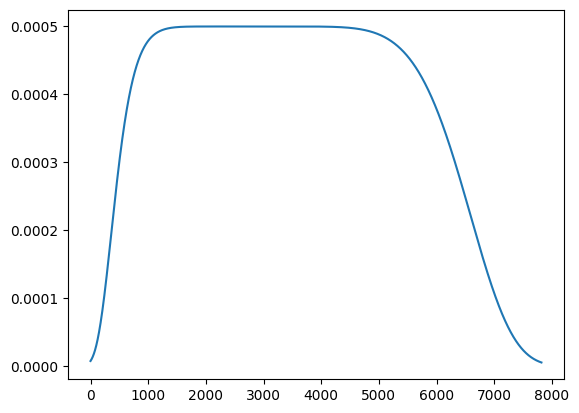

In [7]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# import matplotlib.pyplot as plt
# plt.plot(learning_rates)

In [ ]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(device)
        for mix_transform in mix_transforms:
            x, y = mix_transform(x, y) 

        logits = model(x)
        ce_loss = torch.nn.CrossEntropyLoss()(logits, y)
        ce_loss.backward()
        train_loss.append(ce_loss.item())
        
        with torch.no_grad():
            s = [x, model.stem(x)]
            for stage in model.stages:
                s.append(stage(s[-1]))
        recon_loss = 0
        for i, stage in enumerate(inv_stages):
            recon_loss += torch.nn.functional.mse_loss(stage(s[-1-i]),s[-i-2])
        recon_loss.backward()
        train_loss[-1] += recon_loss.item()

        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            inv_optimizer.step()
            inv_optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            inv_schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(device)
        x = x.to(device)
        with torch.no_grad():
            logits = model(x)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= len(dataset_valid)
    
    mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")

    if i_epoch == 50:
        torch.save({
            'i_epoch': i_epoch,
            'learning_rates': learning_rates,
            'smoothed_y': smoothed_y,
            'valid_acc': valid_acc,
            'config': config,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, f"log_{device}_preanneal.pth")

In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [ ]:
plt.plot(valid_acc[80:])

In [ ]:
plt.plot(learning_rates)

In [ ]:
plt.semilogy(smoothed_y)
plt.ylim([0,7])

In [14]:
torch.save({
    'i_epoch': i_epoch,
    'learning_rates': learning_rates,
    'smoothed_y': smoothed_y,
    'valid_acc': valid_acc,
    'config': config,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}, f"../../hf/tft/efficientvit_l1_gn8.pth")